In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
import matplotlib.pyplot as plt
from IPython import display 
import scipy

import pickle
import dask

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 16)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38775 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 67.31 GB


In [3]:
#Load Data
with open("sweep-000m005-010p000_trim.pkl", "rb") as f:
    ra_dec = pickle.load(f)

In [4]:
#Basic cuts and conversion to radians
#ra_dec = dd.from_pandas(ra_dec0)
ra_dec = ra_dec[ra_dec.MASKBITS == 0]
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.z_phot_median>0.01)]
ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]

#Oversampling
oversample = 1
gauss = ra_dec.sample(n = int(oversample*len(ra_dec)), replace = True)
random1 = np.random.normal(loc = 0, scale = 0.1, size = int(oversample*len(ra_dec)))
gauss["z_phot_median"] = gauss["z_phot_median"] + random1*gauss["z_phot_std"]

#Binning by redshift
bins = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned = [ra_dec[np.logical_and(ra_dec.z_phot_median>=i-.025, ra_dec.z_phot_median<=i+.025)] for i in bins]
bins_g = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned_g = [gauss[np.logical_and(gauss.z_phot_median>=i-.025, gauss.z_phot_median<=i+.025)] for i in bins]

#Cartesian coordinates
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
for i in range(0, len(binned)):
    mean = binned[i].z_phot_median.mean()
    binned[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned[i]))
    binned[i]["y"] = cos.comoving_distance(mean)*binned[i]["DEC_r"]
    binned[i]["x"] = cos.comoving_distance(mean)*binned[i]["RA_r"]*np.cos(binned[i]["DEC_r"])
for i in range(0, len(binned_g)):
    mean = binned_g[i].z_phot_median.mean()
    binned_g[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned_g[i]))
    binned_g[i]["y"] = cos.comoving_distance(mean)*binned_g[i]["DEC_r"]
    binned_g[i]["x"] = cos.comoving_distance(mean)*binned_g[i]["RA_r"]*np.cos(binned_g[i]["DEC_r"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [5]:
"""def clusters_dist(binned, binned_g, b):
    sample_real = binned[b]
    massive_sample = sample_real[sample_real.mass>11]
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])
        sample = binned_g[b]
        tree = spatial.cKDTree(sample[["x", "y"]])
        
        r = 2
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True)
        massive_sample.reset_index(inplace=True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        
        reds = sample.z_phot_median
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_red"][i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["med_red"][i] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        clusters = massive_sample[massive_sample.neighbors>5]
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            r = 2
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters.drop(columns = ["neighbor_numbers"])
            clusters["neighbor_numbers"] = pd.Series(neighbors_c)
            
            clusters.sort_values("mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            sample["ncluster"] = np.zeros(len(sample))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                    clusternum+=1
            
            most_massive = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            most_massive = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        most_massive = pd.DataFrame([[]])
        counts = np.array([0])
    return len(clusters), len(most_massive), np.median(counts)"""

'def clusters_dist(binned, binned_g, b):\n    sample_real = binned[b]\n    massive_sample = sample_real[sample_real.mass>11]\n    if len(massive_sample)>0:\n        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])\n        sample = binned_g[b]\n        tree = spatial.cKDTree(sample[["x", "y"]])\n        \n        r = 2\n        neighbors = massive_tree.query_ball_tree(tree, r)\n        counts = np.array([])\n        for i in range(0, len(neighbors)):\n            counts = np.append(counts, len(neighbors[i]))\n        \n        sample.reset_index(inplace=True)\n        massive_sample.reset_index(inplace=True)\n        massive_sample["neighbor_numbers"] = pd.Series(neighbors)\n        massive_sample["neighbors"] = pd.Series(counts)\n        \n        masses = 10**sample.mass\n        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))\n        for i in range (0, len(massive_sample)):\n            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sa

In [6]:
"""dist_clusters = []
dist_most_massive = []
median_gal = []
pbar = display.ProgressBar(len(binned))
pbar.display()
for b in range(0, len(binned), 20):
    pbar.progress = b
    values = clusters_dist(binned, binned_g, b)
    dist_clusters.append(values[0])
    dist_most_massive.append(values[1])
    median_gal.append(values[2])
    print(b)"""

'dist_clusters = []\ndist_most_massive = []\nmedian_gal = []\npbar = display.ProgressBar(len(binned))\npbar.display()\nfor b in range(0, len(binned), 20):\n    pbar.progress = b\n    values = clusters_dist(binned, binned_g, b)\n    dist_clusters.append(values[0])\n    dist_most_massive.append(values[1])\n    median_gal.append(values[2])\n    print(b)'

In [7]:
"""redshift = np.arange(0, len(binned), 20)
a = 1.5
b = 1.7
z0 = 0.7
r = (redshift/100)/z0
plt.plot(redshift, median_gal)
plt.show()
plt.plot(redshift, dist_clusters)
plt.plot(redshift, (50000)*(r**a)*(np.e**-r)**b)
plt.show()
plt.plot(redshift, dist_most_massive)
plt.plot(redshift, (5000)*(r**a)*(np.e**-r)**b)
plt.show()"""

'redshift = np.arange(0, len(binned), 20)\na = 1.5\nb = 1.7\nz0 = 0.7\nr = (redshift/100)/z0\nplt.plot(redshift, median_gal)\nplt.show()\nplt.plot(redshift, dist_clusters)\nplt.plot(redshift, (50000)*(r**a)*(np.e**-r)**b)\nplt.show()\nplt.plot(redshift, dist_most_massive)\nplt.plot(redshift, (5000)*(r**a)*(np.e**-r)**b)\nplt.show()'

In [8]:
sample_real = binned[40]
massive_sample = sample_real[sample_real.mass>11]
"""if len(massive_sample)>0:
    massive_tree = spatial.cKDTree(massive_sample[["x", "y"]], copy_data = True)
    sample = binned_g[40]
    tree = spatial.cKDTree(sample[["x", "y"]], copy_data = True)
    
    neighbors = massive_tree.query_ball_tree(tree, 2)
    neighbor = pd.DataFrame(neighbors)
    counts = np.array([])
    for i in range(0, len(neighbors)):
        counts = np.append(counts, len(neighbors[i]))
        
    sample.reset_index(inplace=True)
    massive_sample.reset_index(inplace=True)
    massive_sample["neighbor_numbers"] = pd.Series(neighbors)
    massive_sample["neighbors"] = pd.Series(counts)"""

'if len(massive_sample)>0:\n    massive_tree = spatial.cKDTree(massive_sample[["x", "y"]], copy_data = True)\n    sample = binned_g[40]\n    tree = spatial.cKDTree(sample[["x", "y"]], copy_data = True)\n    \n    neighbors = massive_tree.query_ball_tree(tree, 2)\n    neighbor = pd.DataFrame(neighbors)\n    counts = np.array([])\n    for i in range(0, len(neighbors)):\n        counts = np.append(counts, len(neighbors[i]))\n        \n    sample.reset_index(inplace=True)\n    massive_sample.reset_index(inplace=True)\n    massive_sample["neighbor_numbers"] = pd.Series(neighbors)\n    massive_sample["neighbors"] = pd.Series(counts)'

In [9]:
@dask.delayed
def mclusters(binned, binned_g, C = 2.5, r = 2):
    sample_real = binned
    massive_sample = sample_real[sample_real.mass>11]
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]], copy_data = True)
        sample = binned_g
        tree = spatial.cKDTree(sample[["x", "y"]], copy_data = True)
        
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True)
        massive_sample.reset_index(inplace=True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["neighbor_mass"][i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
            #Need to aggregate this mass whenever I do an aggregation
        
        reds = sample.z_phot_median
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_red"][i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["med_red"][i] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        massive_sample["mean_x"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_x"][i] = np.mean(sample.x[massive_sample.neighbor_numbers[i]])
        massive_sample["mean_y"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample["mean_y"][i] = np.mean(sample.y[massive_sample.neighbor_numbers[i]])
        
        threshold = C*np.median(counts) #Idea: scale C as 2.7/(1+z)**2 optionally with a boolean for scaling optionally
        clusters = massive_sample[massive_sample.neighbors>=threshold]
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters["cluster_neighbor_numbers"] = pd.Series(neighbors_c) #Neighboring galaxies with neighbors>threshold
            
            clusters.sort_values("mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.cluster_neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                            
                    clusternum+=1
            
            cluster_center = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            cluster_center = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        cluster_center = pd.DataFrame([[]])
    
    return cluster_center

In [11]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned)):
    delayed_result = mclusters(binned[b], binned_g[b], r=5)
    delayed_results.append(delayed_result)


In [12]:
results = dask.compute(*delayed_results)

In [13]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])

In [14]:
cluster_centrals["mean_red_z"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [15]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red_z"]*(2/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

In [16]:
cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1
xyradius = 5
zradius = 0.1


for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        com = cos.comoving_distance(gal.mean_red).value
        gal["y_local"] = com*gal["DEC_r"]
        gal["x_local"] = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        gal.ncluster_3D = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = gal.x_local
        y_const = gal.y_local
        r_const = gal.mean_red
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<xyradius).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<xyradius).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<zradius).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "ncluster_3D"] = clusternum
        
        # Saving local x,y coordinates for each galaxy in cluster
        gal.y_individual = com*gal["DEC_r"]
        gal.x_individual = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "y_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "x_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].RA_r*np.cos(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r)
        
        # Cluster averages
        gal.mean_z_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        gal.mean_x_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        gal.mean_y_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_z_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_x_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_y_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


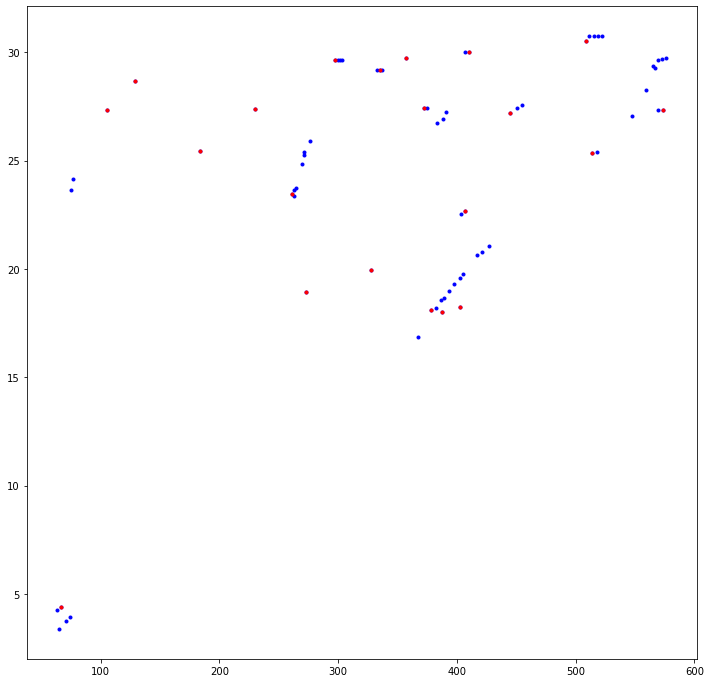

In [17]:
plt.figure(figsize=(12, 12))
cluster_plot_slice = cluster_centrals_3D[np.logical_and(cluster_centrals_3D.y<=-12, cluster_centrals_3D.y>=-16)]
cluster_plot_slice2 = cluster_centrals[np.logical_and(cluster_centrals.y<=-12, cluster_centrals.y>=-16)]
plt.plot(cluster_plot_slice2.x, cluster_plot_slice2.mean_red_z_scaled, ".b")
"""plt.ylim(4, 6)
plt.xlim(70, 80)"""
plt.plot(cluster_plot_slice.x, cluster_plot_slice.mean_red_z_scaled, ".r")
plt.show()

In [18]:
cluster_centrals_3D[["RA", "DEC"]].head(30)

,RA,DEC
18,6.144752,-4.666774
99,5.302622,-1.384859
157,9.373295,-3.185616
16,3.725458,-0.952329
39,7.688579,-1.149253
223,5.554355,-0.609385
216,5.839722,-2.934215
1,3.565943,-0.821370
207,0.885670,-3.792844
19,2.458335,-2.091712


In [19]:
len(cluster_centrals_3D)

1070

## Z distribution: bins

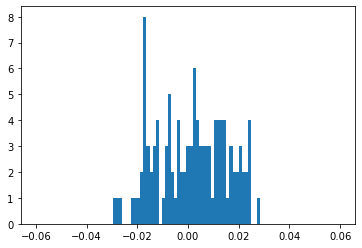

In [20]:
graph_subset = cluster_centrals[np.abs(cluster_centrals.mean_red - np.mean(cluster_centrals.mean_red)) < 0.005]
plt.hist(graph_subset.z_phot_median-graph_subset.mean_red, bins = np.linspace(-0.06, 0.06, 100))
plt.show()

## Z distribution: cluster member galaxies

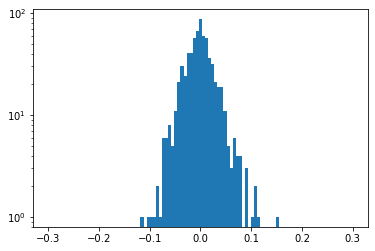

In [21]:
diff = cluster_centrals_3D.z_phot_median-cluster_centrals_3D.mean_z_cluster
plt.hist(diff[diff != 0], bins = np.linspace(-0.3, 0.3, 100), log = True)
plt.show()

## Radius distribution: initial binned aggregation

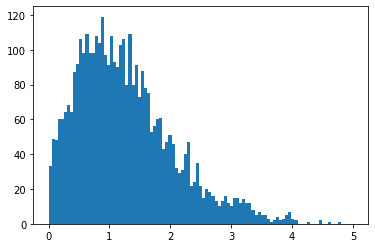

In [22]:
radius = np.sqrt((cluster_centrals.x - cluster_centrals.mean_x)**2 + (cluster_centrals.y - cluster_centrals.mean_y)**2)
radius = radius[radius>0]
radius = radius[radius>1e-2]
plt.hist(radius, bins = np.linspace(0, 5, 100))
plt.show()

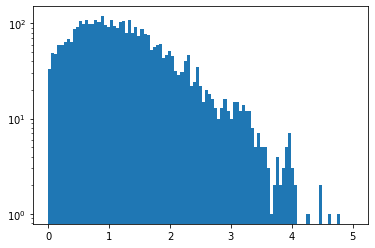

In [23]:
radius = np.sqrt((cluster_centrals.x - cluster_centrals.mean_x)**2 + (cluster_centrals.y - cluster_centrals.mean_y)**2)
radius = radius[radius>0]
radius = radius[radius>1e-2]
plt.hist(radius, bins = np.linspace(0, 5, 100), log=True)
plt.show()

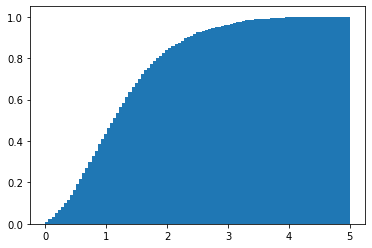

In [24]:
radius = np.sqrt((cluster_centrals.x - cluster_centrals.mean_x)**2 + (cluster_centrals.y - cluster_centrals.mean_y)**2)
radius = radius[radius>0]
radius = radius[radius>1e-2]
plt.hist(radius, bins = np.linspace(0, 5, 100), cumulative = True, density=True)
plt.show()

## Radius distribution: cluster member galaxies

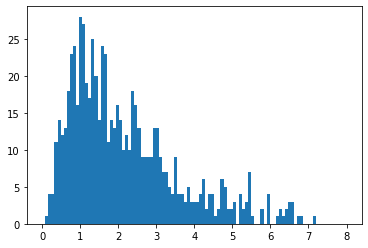

In [25]:
radius = np.sqrt((cluster_centrals_3D.x_individual - cluster_centrals_3D.mean_x_cluster)**2 + (cluster_centrals_3D.y_individual - cluster_centrals_3D.mean_y_cluster)**2)
radius = radius[radius>0]
radius = radius[radius>1e-10]
plt.hist(radius, bins = np.linspace(0, 8, 100))
plt.show()

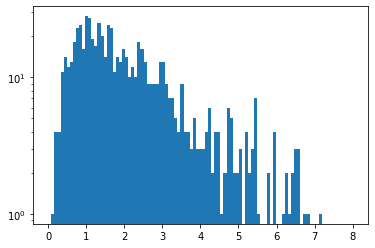

In [26]:
radius = np.sqrt((cluster_centrals_3D.x_individual - cluster_centrals_3D.mean_x_cluster)**2 + (cluster_centrals_3D.y_individual - cluster_centrals_3D.mean_y_cluster)**2)
radius = radius[radius>0]
radius = radius[radius>1e-10]
plt.hist(radius, bins = np.linspace(0, 8, 100), log = True)
plt.show()

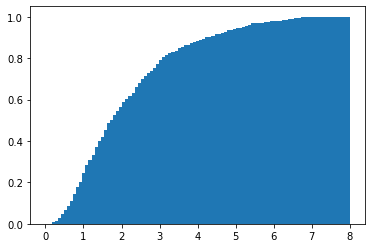

In [27]:
radius = np.sqrt((cluster_centrals_3D.x_individual - cluster_centrals_3D.mean_x_cluster)**2 + (cluster_centrals_3D.y_individual - cluster_centrals_3D.mean_y_cluster)**2)
radius = radius[radius>0]
radius = radius[radius>1e-10]
plt.hist(radius, bins = np.linspace(0, 8, 100), cumulative = True, density=True)
plt.show()

# TO DO:

1. Propagate the masses through aggregation
2. CKDTree neighbors counts in bins of r (normalized by surface area of the bin) for z = .45 to z = .55 (see neighbor counts) (visualize with line graph/histogram in r)
3. For z = 0.45 to z = .55, explore whether C needs to be changed
4. For full set, using value from step 3, explore whether making .25/(1+z)^2 is a good idea

Neighbor counts: 

CKDTree count neighbors in sample for cluster_center

CKDTree count neighbors in clusters for cluster_center

## Comparing results of r = 2 and r = 3.5

In [66]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned)):
    delayed_result = mclusters(binned[b], binned_g[b], r=2)
    delayed_results.append(delayed_result)

In [67]:
results = dask.compute(*delayed_results)

In [68]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])

In [69]:
cluster_centrals["mean_red_z"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [70]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red_z"]*(2/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

In [71]:
cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1
xyradius = 2
zradius = 0.1


for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        com = cos.comoving_distance(gal.mean_red).value
        gal["y_local"] = com*gal["DEC_r"]
        gal["x_local"] = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        gal.ncluster_3D = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = gal.x_local
        y_const = gal.y_local
        r_const = gal.mean_red
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<xyradius).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<xyradius).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<zradius).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "ncluster_3D"] = clusternum
        
        # Saving local x,y coordinates for each galaxy in cluster
        gal.y_individual = com*gal["DEC_r"]
        gal.x_individual = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "y_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "x_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].RA_r*np.cos(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r)
        
        # Cluster averages
        gal.mean_z_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        gal.mean_x_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        gal.mean_y_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_z_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_x_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_y_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [72]:
cluster_centrals_3D_r2 = cluster_centrals_3D.copy()

In [73]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned)):
    delayed_result = mclusters(binned[b], binned_g[b], r=3.5)
    delayed_results.append(delayed_result)

In [74]:
results = dask.compute(*delayed_results)

In [75]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])

In [76]:
cluster_centrals["mean_red_z"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [77]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red_z"]*(2/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

In [78]:
cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1
xyradius = 3.5
zradius = 0.1


for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        com = cos.comoving_distance(gal.mean_red).value
        gal["y_local"] = com*gal["DEC_r"]
        gal["x_local"] = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        gal.ncluster_3D = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = gal.x_local
        y_const = gal.y_local
        r_const = gal.mean_red
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<xyradius).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<xyradius).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<zradius).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "ncluster_3D"] = clusternum
        
        # Saving local x,y coordinates for each galaxy in cluster
        gal.y_individual = com*gal["DEC_r"]
        gal.x_individual = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "y_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "x_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].RA_r*np.cos(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r)
        
        # Cluster averages
        gal.mean_z_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        gal.mean_x_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        gal.mean_y_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_z_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_x_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_y_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [79]:
cluster_centrals_3D_r3p5 = cluster_centrals_3D.copy()

In [80]:
len(cluster_centrals_3D_r2)

5169

In [81]:
len(cluster_centrals_3D_r3p5)

2216

In [85]:
difference.columns

Index(['level_0', 'index', 'z_phot_median', 'z_phot_std', 'mass', 'RELEASE',
       'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'RA_r', 'DEC_r', 'z', 'y',
       'x', 'neighbor_numbers', 'neighbors', 'neighbor_mass', 'mean_red',
       'med_red', 'mean_x', 'mean_y', 'cluster_neighbor_numbers', 'ncluster',
       'mean_red_z', 'mean_red_z_scaled', 'ncluster_3D', 'y_local', 'x_local',
       'y_individual', 'x_individual', 'mean_z_cluster', 'mean_x_cluster',
       'mean_y_cluster'],
      dtype='object')

In [86]:
difference = cluster_centrals_3D_r2[np.logical_and(~cluster_centrals_3D_r2.RA.isin(cluster_centrals_3D_r3p5.RA), ~cluster_centrals_3D_r2.DEC.isin(cluster_centrals_3D_r3p5.DEC))]
difference[['RA', 'DEC', 'neighbors', 'z_phot_median', 'MASKBITS']].head(50)

,RA,DEC,neighbors,z_phot_median,MASKBITS
28,2.018337,-3.810984,60.0,0.222547,2200.0
23,5.825077,-0.102710,117.0,0.151832,2334.0
206,7.513821,-3.961296,8.0,0.747184,2818.0
50,3.675424,-0.154025,69.0,0.243816,2078.0
38,9.238262,-0.372327,66.0,0.221474,2200.0
10,4.170721,-1.281445,75.0,0.174265,2200.0
21,6.108818,-1.553279,6.0,0.794070,0.0
57,2.183352,-4.732066,28.0,0.456039,0.0
291,0.268448,-0.590309,19.0,0.578555,0.0
28,3.326528,-1.615682,74.0,0.190983,0.0


## This time comparing different values for C at r = 2

In [87]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned)):
    delayed_result = mclusters(binned[b], binned_g[b], r=2, C = 2.5)
    delayed_results.append(delayed_result)

In [88]:
results = dask.compute(*delayed_results)

In [89]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])

In [90]:
cluster_centrals["mean_red_z"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [91]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red_z"]*(2/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

In [92]:
cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1
xyradius = 2
zradius = 0.1


for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        com = cos.comoving_distance(gal.mean_red).value
        gal["y_local"] = com*gal["DEC_r"]
        gal["x_local"] = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        gal.ncluster_3D = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = gal.x_local
        y_const = gal.y_local
        r_const = gal.mean_red
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<xyradius).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<xyradius).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<zradius).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "ncluster_3D"] = clusternum
        
        # Saving local x,y coordinates for each galaxy in cluster
        gal.y_individual = com*gal["DEC_r"]
        gal.x_individual = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "y_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "x_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].RA_r*np.cos(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r)
        
        # Cluster averages
        gal.mean_z_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        gal.mean_x_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        gal.mean_y_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_z_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_x_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_y_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [93]:
cluster_centrals_3D_c2p5 = cluster_centrals_3D.copy()

In [94]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned)):
    delayed_result = mclusters(binned[b], binned_g[b], r=2, C = 3)
    delayed_results.append(delayed_result)

In [95]:
results = dask.compute(*delayed_results)

In [96]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])

In [97]:
cluster_centrals["mean_red_z"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [98]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red_z"]*(2/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

In [99]:
cluster_centrals.sort_values("mass", inplace = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals))
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1
xyradius = 2
zradius = 0.1


for index, gal in cluster_centrals.iterrows():
    if gal.ncluster_3D == 0:
        com = cos.comoving_distance(gal.mean_red).value
        gal["y_local"] = com*gal["DEC_r"]
        gal["x_local"] = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        gal.ncluster_3D = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = gal.x_local
        y_const = gal.y_local
        r_const = gal.mean_red
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<xyradius).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<xyradius).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<zradius).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "ncluster_3D"] = clusternum
        
        # Saving local x,y coordinates for each galaxy in cluster
        gal.y_individual = com*gal["DEC_r"]
        gal.x_individual = com*gal["RA_r"]*np.cos(gal["DEC_r"])
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "y_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "x_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z))].RA_r*np.cos(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].DEC_r)
        
        # Cluster averages
        gal.mean_z_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        gal.mean_x_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        gal.mean_y_cluster = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_z_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].z_phot_median)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_x_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].x_local)
        cluster_centrals.loc[((test_x) & (test_y) & (test_z)), "mean_y_cluster"] = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z))].y_local)
        
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals.sort_values(by = ['ncluster_3D','mass'], ascending = False).groupby('ncluster_3D').head(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


In [100]:
cluster_centrals_3D_c3 = cluster_centrals_3D.copy()

In [101]:
len(cluster_centrals_3D_c2p5)

5169

In [102]:
len(cluster_centrals_3D_c3)

3942

In [103]:
difference = cluster_centrals_3D_c2p5[np.logical_and(~cluster_centrals_3D_c2p5.RA.isin(cluster_centrals_3D_c3.RA), ~cluster_centrals_3D_c2p5.DEC.isin(cluster_centrals_3D_c3.DEC))]
difference[['RA', 'DEC', 'neighbors', 'z_phot_median']].head(50)

,RA,DEC,neighbors,z_phot_median
28,2.018337,-3.810984,60.0,0.222547
206,7.513821,-3.961296,8.0,0.747184
50,3.675424,-0.154025,69.0,0.243816
38,9.238262,-0.372327,66.0,0.221474
10,4.170721,-1.281445,75.0,0.174265
57,2.183352,-4.732066,28.0,0.456039
28,3.326528,-1.615682,74.0,0.190983
100,5.950358,-4.169422,33.0,0.414220
95,6.704648,-2.090372,5.0,0.771861
529,4.408244,-0.482886,5.0,0.820989


# Images for graphic in grant

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(sample_real.RA, sample_real.DEC, ".", alpha=0.12)
#plt.plot(cluster_centrals_3D[np.logical_and(cluster_centrals_3D.z_phot_median>0.45, cluster_centrals_3D.z_phot_median<0.55)].RA, cluster_centrals_3D[np.logical_and(cluster_centrals_3D.z_phot_median>0.45, cluster_centrals_3D.z_phot_median<0.55)].DEC, ".r", alpha=1)
plt.xlim(5, 10)
plt.xlabel("Right Ascension in degrees", fontsize=14)
plt.ylabel("Declination in degrees", fontsize=14)
plt.title("Patch of sky at redshift=0.5")
plt.ylim(-5, -2.5)
plt.show()

NameError: name 'sample_real' is not defined

<Figure size 576x576 with 0 Axes>

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(sample_real.RA, sample_real.DEC, ".", alpha=0.12)
plt.plot(6.750347, -4.223251, ".k", ms=22)
plt.plot(cluster_centrals_3D[np.logical_and(cluster_centrals_3D.z_phot_median>0.45, cluster_centrals_3D.z_phot_median<0.55)].RA, cluster_centrals_3D[np.logical_and(cluster_centrals_3D.z_phot_median>0.45, cluster_centrals_3D.z_phot_median<0.55)].DEC, "or", ms=5, alpha=1)
plt.xlim(5, 10)
plt.ylim(-5, -2.5)
plt.xlabel("Right Ascension in degrees", fontsize=14)
plt.ylabel("Declination in degrees", fontsize=14)
plt.title("Same patch but with galaxy clusters overlaid in red")
plt.show()

NameError: name 'sample_real' is not defined

<Figure size 576x576 with 0 Axes>

To Do:
4. Plot histogram of (galaxy_redshift - mean_red_of_cluster) where you do this for all clusters
5. Plot histogram of (individual_cluster_redshift - mean_red_of_cluster) where you do this for all clusters

Files:
1. Build a dataframe that contains the center of every tile
2. Using that, choose the 8 nearest tiles, cut off the parts >r away from the edge to current tile and add them to binned_g

Optimize code as much as possible (?)

# Choosing correct value for C
#### Requires returning the median in function

In [29]:
results[40][1][results[40][1].neighbors>=3.5*results[40][2]][['RA', 'DEC','neighbors']].head()

,RA,DEC,neighbors
425,3.725458,-0.952329,39.0
522,8.719883,-3.043524,57.0
154,6.475867,-4.323628,51.0


In [30]:
results[40][1][np.logical_and(results[40][1].neighbors>=3*results[40][2], results[40][1].neighbors<3.5*results[40][2])][['RA', 'DEC', 'neighbors']].head(25)

,RA,DEC,neighbors
73,6.750347,-4.223251,33.0
530,8.655852,-3.026742,38.0
909,1.725383,-0.688769,34.0
637,9.673345,-4.927279,33.0
639,9.692866,-4.931662,34.0
503,8.236548,-1.658904,35.0
691,0.862389,-4.306142,35.0


In [31]:
results[40][1][np.logical_and(results[40][1].neighbors>=2.5*results[40][2], results[40][1].neighbors<3*results[40][2])][['RA', 'DEC', 'neighbors']].head(25)

,RA,DEC,neighbors
438,3.340323,-4.071690,30.0
846,1.780357,-0.709065,28.0
292,7.807836,-0.210069,30.0
202,2.164926,-4.705414,30.0
437,3.310755,-4.098124,29.0
638,9.665872,-4.942027,31.0
46,6.793873,-4.228611,29.0
67,6.511371,-4.264110,31.0
149,6.106854,-0.630238,29.0
256,2.772526,-1.011505,28.0


In [32]:
results[40][1][np.logical_and(results[40][1].neighbors>=2*results[40][2], results[40][1].neighbors<2.5*results[40][2])][['RA', 'DEC', 'neighbors']].head(25)

,RA,DEC,neighbors
777,5.937200,-3.432460,23.0
23,6.157316,-4.539484,22.0
933,1.642744,-0.353180,23.0
22,6.136149,-4.546811,27.0
736,0.569253,-1.548973,22.0
627,9.503089,-2.917561,24.0
836,5.767540,-4.684062,23.0
690,0.836086,-4.325868,24.0
880,1.086536,-3.274483,24.0
320,7.840899,-0.110379,23.0


In [33]:
results[40][1][np.logical_and(results[40][1].neighbors>=1.5*results[40][2], results[40][1].neighbors<2*results[40][2])][['RA', 'DEC', 'neighbors']].sample(25)

,RA,DEC,neighbors
119,6.637784,-1.996886,18.0
277,7.128105,-1.455357,17.0
665,4.027244,-0.308137,17.0
934,1.321781,-1.484976,18.0
822,5.464762,-3.154262,18.0
675,4.347615,-4.175145,18.0
898,1.431657,-1.997010,21.0
26,6.254288,-4.455207,18.0
509,8.991316,-2.649582,19.0
572,9.867243,-2.680981,17.0


# Choosing correct value for R

In [53]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 1.5, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [54]:
results[40][1][['RA', 'DEC','neighbors']].sample(25)

,RA,DEC,neighbors
312,1.743151,-2.130701,16.0
52,6.136352,-0.654803,21.0
119,7.078596,-2.550223,24.0
281,0.822227,-3.126575,16.0
92,2.891421,-3.928083,17.0
219,8.655743,-1.950261,21.0
124,7.887594,-4.541838,18.0
170,3.264008,-4.342208,19.0
289,5.107213,-2.720071,17.0
113,7.814251,-0.373924,17.0


In [107]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 2, C = 3)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [108]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
28,3.336221,-4.075040,34.0
29,3.769710,-0.955487,36.0
54,8.655852,-3.026742,38.0
66,9.673345,-4.927279,33.0
1,6.750347,-4.223251,33.0
77,1.725383,-0.688769,34.0
24,3.725458,-0.952329,39.0
62,9.478786,-0.113307,33.0
46,8.719883,-3.043524,57.0
34,8.236548,-1.658904,35.0


In [90]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 2.5, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [91]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
33,7.792165,-0.183502,42.0
79,9.637387,-1.533327,41.0
45,3.783597,-0.922071,44.0
75,8.722573,-2.963398,41.0
80,9.673345,-4.927279,44.0
2,6.793873,-4.228611,45.0
31,6.421222,-4.296373,52.0
8,6.511371,-4.264110,50.0
10,6.750347,-4.223251,47.0
77,8.788660,-3.019410,44.0


In [59]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 3, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [60]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
69,1.695736,-0.649135,57.0
38,3.752427,-0.936903,58.0
62,8.653258,-2.958986,58.0
11,6.750347,-4.223251,58.0
31,6.421222,-4.296373,72.0
9,6.511371,-4.264110,69.0
64,8.788660,-3.019410,63.0
55,8.655852,-3.026742,78.0
37,3.736976,-0.936550,59.0
6,6.568982,-4.329541,58.0


In [61]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 3.5, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [62]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
46,1.695736,-0.649135,83.0
0,6.793873,-4.228611,79.0
43,8.722573,-2.963398,95.0
20,6.421222,-4.296373,84.0
7,6.511371,-4.264110,82.0
44,8.788660,-3.019410,84.0
38,8.655852,-3.026742,92.0
4,6.568982,-4.329541,83.0
30,8.719883,-3.043524,100.0
12,6.475867,-4.323628,84.0


In [63]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned[0:50])):
    delayed_result = mclusters(binned[b], binned_g[b], r = 4, C = 2.5)
    delayed_results.append(delayed_result)
results = dask.compute(*delayed_results)

In [64]:
results[40][1][['RA', 'DEC','neighbors']].head(25)

,RA,DEC,neighbors
42,1.695736,-0.649135,99.0
39,8.740076,-2.943072,98.0
31,8.655852,-3.026742,104.0
34,8.658873,-3.017270,108.0
5,6.511371,-4.264110,97.0
40,8.788660,-3.019410,102.0
1,6.568982,-4.329541,105.0
23,8.719883,-3.043524,113.0
9,6.475867,-4.323628,98.0
